In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
import scikit_posthocs as sp
from scipy.stats import kruskal

pd.set_option('display.max_columns', None)  # Отображение всех столбцов
# pd.set_option('display.max_rows', None)  # Ото----бражение всех строк   

In [93]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')




volunteers = volunteers[volunteers.athlete_age < 100]
starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 5000]


cnt_ludei = starts.groupby(['event_name', 'event_date', 'region']).agg(
    cnt_runners = ('athlete_id', 'count')
)



ages_14 = starts[starts['athlete_age'] == 14]['athlete_id'].unique()
ages_15 = starts[starts['athlete_age'] == 15]['athlete_id'].unique()
common_athletes = set(ages_14) & set(ages_15)
starts = starts[~starts['athlete_id'].isin(common_athletes)]



starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])   # удаление где 0 волонтеров в сумме было


unique_dates = (
    pd.concat([
        starts[['athlete_id', 'event_date']],
        volunteers[['athlete_id', 'event_date']]
    ])
    .drop_duplicates()
)
date_counts = unique_dates.groupby('athlete_id').size().reset_index(name='unique_event_count')
date_counts['is_repeated'] = (date_counts['unique_event_count'] > 1).astype(int)
starts = starts.merge(date_counts[['athlete_id', 'is_repeated']], on='athlete_id', how='left')


# starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  
starts = starts[starts.event_date <= '2023-10-15']


newbie = starts[starts['is_newbie'] == 1]
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = first_runs[first_runs.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
come_with_didnt_come = come_with_didnt_come.merge(cnt_ludei,on=['event_name', 'event_date', 'region'], how="left")
print(len(come_with_didnt_come))

16708


,event_date,event_name,cnt_runners,cluster
1081,2023-04-29,Затюменский,539.0,2
1791,2023-06-24,Затюменский,404.0,2
2232,2023-07-29,Затюменский,545.0,2
2325,2023-08-05,Затюменский,353.0,2
2411,2023-08-12,Затюменский,303.0,2
2598,2023-08-26,Затюменский,307.0,2
2797,2023-09-09,Затюменский,333.0,2
2929,2023-09-16,Парк Горького,350.0,2
3094,2023-09-30,Затюменский,646.0,2


Кластеризация по количеству участников


In [126]:
event_data = (come_with_didnt_come
              .groupby(['event_date', 'event_name'], as_index=False)
              .agg({'cnt_runners': 'mean'}))

event_data = event_data[event_data.cnt_runners < 500]

k = 3
X = event_data[['cnt_runners']]
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
event_data['cluster'] = kmeans.fit_predict(X)

cluster_stats = (event_data
                 .groupby('cluster')
                 .agg(
                     cluster_min=('cnt_runners', 'min'),
                     cluster_max=('cnt_runners', 'max'),
                     cluster_mean=('cnt_runners', 'mean')
                 )
                 .reset_index())


cluster_stats = cluster_stats.sort_values('cluster_mean')
cluster_stats['new_cluster'] = range(len(cluster_stats))


cluster_map = dict(zip(cluster_stats['cluster'], cluster_stats['new_cluster']))


event_data['cluster'] = event_data['cluster'].map(cluster_map)


final_cluster_stats = (event_data
                       .groupby('cluster')
                       .agg(
                           cluster_min=('cnt_runners', 'min'),
                           cluster_max=('cnt_runners', 'max'),
                           cluster_mean=('cnt_runners', 'mean')
                       )
                       .reset_index()
                       .sort_values('cluster'))


print("Интервалы кластеров по cnt_runners:")
for i, row in final_cluster_stats.iterrows():
    print(f"Кластер {int(row['cluster'])}: от {row['cluster_min']} до {row['cluster_max']} участников (среднее {row['cluster_mean']:.2f})")

if 'cluster' in come_with_didnt_come.columns:
    come_with_didnt_come = come_with_didnt_come.drop(columns=['cluster'])

come_with_didnt_come = come_with_didnt_come.merge(
    event_data[['event_date', 'event_name', 'cluster']],
    on=['event_date', 'event_name'],
    how='left'
)



cluster_counts = come_with_didnt_come.groupby('cluster').size().reset_index(name='count')
print("\n Число наблюдений (участников) в каждом кластере:")
print(cluster_counts)


Интервалы кластеров по cnt_runners:
Кластер 0: от 2.0 до 46.0 участников (среднее 24.96)
Кластер 1: от 47.0 до 138.0 участников (среднее 67.52)
Кластер 2: от 140.0 до 404.0 участников (среднее 209.65)

 Число наблюдений (участников) в каждом кластере:
   cluster  count
0      0.0   8113
1      1.0   5836
2      2.0   1865


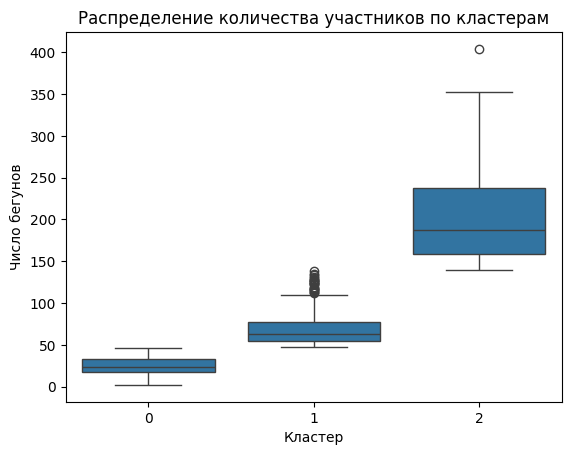

In [127]:
sns.boxplot(x='cluster', y='cnt_runners', data=event_data)
plt.title("Распределение количества участников по кластерам")
plt.ylabel('Число бегунов')
plt.xlabel('Кластер')
plt.show()

Проведем тест критерием Краскелла-Уоллиса, а также тест Данна для попарных сравнений кластеров

In [128]:
import pandas as pd


groups = [event_data.loc[event_data['cluster'] == c, 'cnt_runners'] for c in range(k)]
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis test: H-statistic =", stat, ", p-value =", p_value)


if p_value < 0.05:
    posthoc = sp.posthoc_dunn([event_data.loc[event_data['cluster'] == c , 'cnt_runners'] for c in range(k)], val_col='value', group_col='group', p_adjust='bonferroni')
    print("Результат пост-хок анализа (тест Данна):")
    print(posthoc)
else:
    print("Нет статистически значимых различий между группами (по тесту Краскала-Уоллиса).")


Kruskal-Wallis test: H-statistic = 1795.346461222715 , p-value = 0.0
Результат пост-хок анализа (тест Данна):
              1         2             3
1  1.000000e+00  0.000000  6.936038e-47
2  0.000000e+00  1.000000  2.258436e-02
3  6.936038e-47  0.022584  1.000000e+00


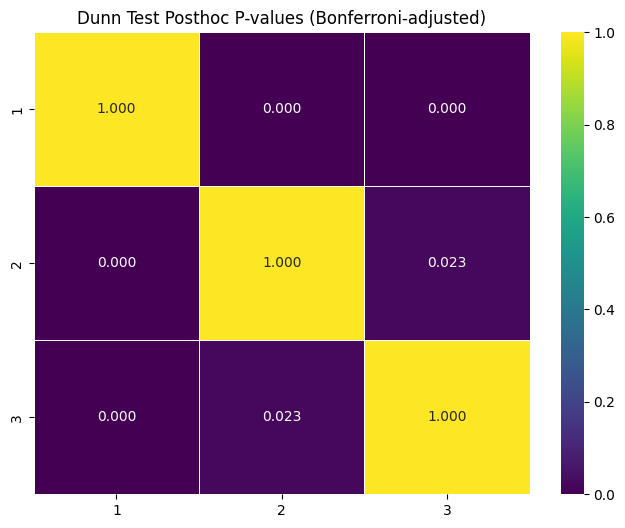

In [131]:
plt.figure(figsize=(8,6))
sns.heatmap(posthoc, annot=True, cmap='viridis', linewidths=0.5, fmt=".3f")
plt.title("Dunn Test Posthoc P-values (Bonferroni-adjusted)")
plt.show()


Все кластеры различаются статзначимо


# 0. Корреляции с is_repeated

In [3]:
numeric_cor = come_with_didnt_come.select_dtypes(include=['number'])
print(numeric_cor.corr(method='spearman')['is_repeated'].sort_values(ascending=False))

is_repeated                          1.000000
rain.1h                              0.186055
athlete_age                          0.104506
is_male                              0.035946
wind_speed                           0.031992
wind_deg                             0.030569
Составление отчёта                   0.012926
Пейсер                               0.012401
Координатор парковки                 0.008598
Сурдопереводчик                      0.005589
Организация финиша                   0.003931
Лидер для слабовидящих               0.000608
Раздача карточек позиций            -0.012038
pressure                            -0.017352
temp                                -0.018786
clouds                              -0.021863
feels_like                          -0.022996
Подготовка мероприятия              -0.024240
humidity                            -0.030813
Проведение разминки                 -0.032440
Инструктаж новых участников         -0.035377
Ведущий велосипед                 

In [4]:
display(come_with_didnt_come.head(2))

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers,cnt_runners
0,4805,790126883,Северное Тушино,2023-01-01,Москва,Москва,2051,женский,23,1,0.66,-4.61,1006,100,0.66,100,6.00,200,Clouds,overcast clouds,NaN,NaN,"плитка, асфальт, грунт",0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1,16.0,28
1,4816,790126915,Петергоф Александрийский,2023-01-01,Санкт-Петербург,Санкт-Петербург,1634,женский,36,1,2.71,-1.99,997,95,1.99,100,5.95,263,Clouds,overcast clouds,NaN,NaN,грунт,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,1,20.0,55


# 1.0. Общий катбуст для кол-ва волонтеров

In [5]:
from catboost import CatBoostClassifier, Pool  
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_newbie',  'is_newbie',
    'athlete_gender', 'weather.main','weather.description','track_description_surface',
 #   'dew_point','is_male',
    'cnt_volunteers',
    #'humidity','finish_time', 'athlete_age', 'athlete_gender', 'wind_speed', 'feels_like', 
    #'pressure', 'temp', 
    # 'snow.1h', 'rain.1h', 'weather.main', 'weather.description', 'track_description_surface', 'wind_deg', 'clouds', 
    #'cnt_runners'
], axis=1)  
y = come_with_didnt_come['is_repeated']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
#categorical_cols = ['athlete_gender', 'weather.main', 'weather.description', 'track_description_surface']

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1,verbose=0)  #,cat_features=categorical_cols)  
print('катбуст начальный со всеми переменными')
model.fit(X_train, y_train)  


preds = model.predict(X_test)  
cm = confusion_matrix(y_test, preds)
print(cm)
print(f'Accuracy: {accuracy_score(y_test, preds):.2f}') 




feature_importances = model.get_feature_importance()  
importance_df = pd.DataFrame({  
    'Feature': X.columns,  # Используйте реальные имена признаков  
    'Importance': feature_importances  
})  

# Сортировка значений важности в порядке убывания  
importance_df = importance_df.sort_values(by='Importance', ascending=False)  

display(importance_df)

feature_importance = model.get_feature_importance(
    data=Pool(X_train, y_train),
    type="FeatureImportance",
    prettified=True
)

print(feature_importance)

катбуст начальный со всеми переменными
[[ 763  767]
 [ 455 1357]]
Accuracy: 0.63


,Feature,Importance
0,finish_time,13.039765
1,athlete_age,12.350153
40,cnt_runners,9.158236
8,wind_speed,6.534607
6,dew_point,6.301589
9,wind_deg,5.118972
2,temp,4.980409
3,feels_like,4.944056
5,humidity,4.928256
4,pressure,4.829230


                           Feature Id  Importances
0                         finish_time    13.039765
1                         athlete_age    12.350153
2                         cnt_runners     9.158236
3                          wind_speed     6.534607
4                           dew_point     6.301589
5                            wind_deg     5.118972
6                                temp     4.980409
7                          feels_like     4.944056
8                            humidity     4.928256
9                            pressure     4.829230
10                             clouds     2.436468
11                             Маршал     1.958982
12                           Фотограф     1.928423
13                Сортировка карточек     1.901745
14           Сканирование штрих-кодов     1.644342
15                         Секундомер     1.619625
16                            rain.1h     1.426944
17            Связи с общественностью     1.310223
18                        Орган

# 1.1. Общий катбуст для has_volunteer и корреляции с is_repeated и has_volunteer

In [6]:
volunteer_columns = come_with_didnt_come.columns[24:51]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = come_with_didnt_come.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (come_with_didnt_come[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  
has_volunt_numeric = has_volunt.select_dtypes(include=['number'])
display(has_volunt_numeric.corr(method='spearman')['is_repeated'].sort_values(ascending=False))

is_repeated                              1.000000
rain.1h                                  0.186055
athlete_age                              0.104506
is_male                                  0.035946
wind_speed                               0.031992
wind_deg                                 0.030569
has_Пейсер                               0.013480
has_Составление отчёта                   0.012949
has_Координатор парковки                 0.008598
has_Проведение разминки                  0.008100
has_Сурдопереводчик                      0.005589
has_Организация финиша                   0.005043
has_Лидер для слабовидящих               0.000556
has_Замыкающий                          -0.011619
has_Организатор                         -0.014955
pressure                                -0.017352
has_Раздача карточек позиций            -0.018588
temp                                    -0.018786
has_Сканирование штрих-кодов            -0.020241
has_Секундомер                          -0.021316


In [8]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Подразумевается, что come_with_didnt_come уже загружен
# и содержит необходимые данные
X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 
                                       'is_newbie', 'athlete_gender', 'weather.main','weather.description','track_description_surface', 
                                       'cnt_volunteers'], axis=1)   
y = come_with_didnt_come['is_repeated']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
print("Начальная модель со всеми признаками:")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")

# Получаем начальные важности
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
display(importance_df)

# Теперь сделаем бутстрап оценку
n_bootstrap = 50  # Количество бутстрап-итераций (можно увеличить для большей точности)
np.random.seed(42)

features = X.columns
bootstrap_importances = np.zeros((n_bootstrap, len(features)))

for i in range(n_bootstrap):
    # Генерируем bootstrap-выборку индексов
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_boot = X_train.iloc[bootstrap_indices]
    y_boot = y_train.iloc[bootstrap_indices]

    # Обучаем модель на бутстрап-выборке
    model_boot = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0)
    model_boot.fit(X_boot, y_boot)

    # Получаем важности признаков на бутстрап-выборке
    fi = model_boot.get_feature_importance(Pool(X_boot, y_boot))
    bootstrap_importances[i, :] = fi

# Теперь у нас есть матрица bootstrap_importances размером [n_bootstrap, кол-во признаков],
# где каждая строка — это вектор важностей из одного bootstrap-повтора.

# Рассчитаем среднее, стандартное отклонение и доверительные интервалы для важностей
mean_importances = bootstrap_importances.mean(axis=0)
std_importances = bootstrap_importances.std(axis=0)

# 95% доверительный интервал (можно изменить уровень)
alpha = 0.05
lower_bound = np.percentile(bootstrap_importances, 100*alpha/2, axis=0)
upper_bound = np.percentile(bootstrap_importances, 100*(1 - alpha/2), axis=0)

bootstrap_results = pd.DataFrame({
    'Feature': features,
    'Mean_Importance': mean_importances,
    'Std_Importance': std_importances,
    'CI_lower': lower_bound,
    'CI_upper': upper_bound
}).sort_values(by='Mean_Importance', ascending=False)

display(bootstrap_results)

# Интерпретация:
# Если доверительный интервал для важности признака не включает нулевые значения (или около нуля),
# можно говорить о том, что этот признак стабильно вносит вклад в модель.
# Это не "p-value" в строгом смысле, но дает понимание устойчивости важности.

Начальная модель со всеми признаками:
Confusion Matrix:
 [[ 763  767]
 [ 455 1357]]
Accuracy: 0.63


,Feature,Importance
0,finish_time,13.039765
1,athlete_age,12.350153
40,cnt_runners,9.158236
8,wind_speed,6.534607
6,dew_point,6.301589
9,wind_deg,5.118972
2,temp,4.980409
3,feels_like,4.944056
5,humidity,4.928256
4,pressure,4.829230


,Feature,Mean_Importance,Std_Importance,CI_lower,CI_upper
0,finish_time,14.796507,0.694700,13.668946,16.167652
1,athlete_age,12.141894,0.500369,11.500480,13.185819
40,cnt_runners,8.082520,0.886073,6.329314,9.633457
8,wind_speed,6.340137,0.572134,5.395017,7.489299
9,wind_deg,5.918199,0.541646,4.827180,6.997252
6,dew_point,5.742971,0.544269,4.746414,7.009050
4,pressure,5.054465,0.449238,4.328544,6.078685
5,humidity,4.761447,0.478871,3.833450,5.636861
2,temp,4.679363,0.629653,3.723968,6.259943
3,feels_like,4.517877,0.595125,3.291541,5.642580
